In [1]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_dir = "/content/drive/My Drive/Polygence/Audrey/"

In [3]:
% matplotlib inline
import matplotlib.pyplot as plt
import json
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from scipy.stats import pearsonr
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load & Process Data

In [0]:
data = pd.read_csv(root_dir + "/data/all_articles_dependencies.csv")

In [0]:
data = data.groupby("source").filter(lambda x: len(x) > 200)

In [0]:
def get_week(row):
  year, month, day = row["publishedAt"].split("T")[0].split("-")
  return datetime.date(int(year), int(month), int(day)).isocalendar()[1]
data["week"] = data.apply(get_week, axis=1)

In [9]:
data.tail()

,Unnamed: 0,source,author,title,url,publishedAt,content,coref_resolved,Bennet_verbs,Bennet_adjectives,Biden_verbs,Biden_adjectives,Blasio_verbs,Blasio_adjectives,Booker_verbs,Booker_adjectives,Bullock_verbs,Bullock_adjectives,Buttigieg_verbs,Buttigieg_adjectives,Castro_verbs,Castro_adjectives,Delaney_verbs,Delaney_adjectives,Gabbard_verbs,Gabbard_adjectives,Gillibrand_verbs,Gillibrand_adjectives,Harris_verbs,Harris_adjectives,Inslee_verbs,Inslee_adjectives,Klobuchar_verbs,Klobuchar_adjectives,Moulton_verbs,Moulton_adjectives,O'Rourke_verbs,O'Rourke_adjectives,Ryan_verbs,Ryan_adjectives,Sanders_verbs,Sanders_adjectives,Steyer_verbs,Steyer_adjectives,Warren_verbs,Warren_adjectives,Williamson_verbs,Williamson_adjectives,Yang_verbs,Yang_adjectives,Bloomberg_verbs,Bloomberg_adjectives,month,week
12460,12460,usa-today,"USA TODAY, Nicholas Wu, USA TODAY",Marianne Williamson isn't on the debate stage ...,https://www.usatoday.com/story/news/politics/e...,2019-10-16T00:20:27Z,Author and activist Marianne Williamson isn't ...,Author and activist Marianne Williamson isn't ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,said 1\nqualify 1,NaN,NaN,NaN,NaN,NaN,oct,42
12461,12461,usa-today,"USA TODAY, Jason Lalljee, USA TODAY",Marianne Williamson drops out of presidential ...,https://www.usatoday.com/story/news/politics/e...,2020-01-10T17:40:10Z,"Marianne Williamson, who ran a nontraditional ...","Marianne Williamson, who ran a nontraditional ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,said 2\nended 1\nis 1\nran 1\nannounced 1\nacc...,NaN,NaN,NaN,NaN,NaN,jan,2
12462,12462,usa-today,"USA TODAY, Savannah Behrmann, USA TODAY",Bill Taylor departs ambassadorship role in Ukr...,https://www.usatoday.com/story/news/politics/2...,2020-01-02T23:53:09Z,"WASHINGTON – William Taylor, who was top Ameri...","WASHINGTON – William Taylor, who was top Ameri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lays 1,NaN,NaN,NaN,NaN,NaN,jan,1
12463,12463,usa-today,"USA TODAY, Paul Brandus, Opinion columnist","2020 resolution for Trump, Democrats and us: L...",https://www.usatoday.com/story/opinion/2020/01...,2020-01-01T08:15:06Z,I often think of some of the last words spoken...,I often think of some of the last words spoken...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jan,1
12464,12464,usa-today,NaN,"5 dead in flaming plane crash in Lafayette, Lo...",https://www.usatoday.com/story/news/nation/201...,2019-12-28T21:40:00Z,"LAFAYETTE, La. – A small passenger plane en r...","LAFAYETTE, La. – A small passenger plane en r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dec,52


### Global variables

In [0]:
names = ["Warren", "Biden", "Sanders", "Buttigieg", "Harris", "Yang", "Klobuchar"]

In [0]:
leaning_to_source = {"left":["cnn", "msnbc", "new-york-magazine", "the-new-york-times"], 
           "lean_left":["abc-news", "axios", "cbs-news", "nbc-news", "newsweek", "politico", "the-washington-post", "time", "vice-news"],
           "center":["al-jazeera-english", "associated-press", "reuters", "usa-today"],
           "lean_right":["fox-news", "the-american-conservative", "the-hill"],
           "right":["breitbart-news", "national-review"]}

In [0]:
source_to_leaning = {}
for key in leaning_to_source:
  for source in leaning_to_source[key]:
    source_to_leaning[source] = key

## Lemmatizer

In [0]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
def lemmatize(row):
  return lemmatizer.lemmatize(row["word"], pos = row["pos"])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Create long dataframe, one word per row, combine with source & leaning & month

In [0]:
def collecting_words(data, name):
  verbs = "\n".join(data[name + "_verbs"][~data[name + "_verbs"].isnull()].tolist())
  adjectives = "\n".join(data[name+"_adjectives"][~data[name + "_adjectives"].isnull()].tolist())
  l_verbs = []
  for word in verbs.split("\n"):
    if word == "":
      continue
    w, c = word.split(" ")
    for i in range(0,int(c)):
      l_verbs.append(w)
  l_adjectives = []
  for word in adjectives.split("\n"):
    if word == "":
      continue
    w, c = word.split(" ")
    for i in range(0,int(c)):
      l_adjectives.append(w)
  df = pd.DataFrame({"word": l_verbs + l_adjectives, "candidate": [name] * (len(l_verbs)+len(l_adjectives)), "pos": ["v"]*len(l_verbs) + ["a"]*len(l_adjectives)})
  return df

In [0]:
all_words = []
for (source, week), chunk in data.groupby(["source", "week"]):
  for name in names:
    a = collecting_words(chunk, name)
    a["source"] = source
    a["week"] = week
    all_words.append(a)
concat = pd.concat(all_words)

In [0]:
concat["leaning"] = concat["source"].map(source_to_leaning)

In [0]:
# Lemmatize
concat["lemma"] = concat.apply(lemmatize, axis=1)

In [0]:
concat.tail()

,word,candidate,pos,source,week,leaning,lemma
2,'s,Buttigieg,v,usa-today,52,center,'s
3,stands,Buttigieg,v,usa-today,52,center,stand
4,make,Buttigieg,v,usa-today,52,center,make
5,entrusted,Buttigieg,v,usa-today,52,center,entrust
6,is,Buttigieg,v,usa-today,52,center,be


## Load & Process Lexicons

### Connotation Frames of Verbs

In [0]:
connotation = pd.read_csv(root_dir + 'data/annotated_connotation_frames/full_frame_info.txt', sep='\t')
connotation.set_index("verb", inplace=True)
perspective_ws = connotation["Perspective(ws)"].to_dict()
effect_o = connotation["Effect(o)"].to_dict()

In [0]:
concat["perspective(ws)"] = concat["lemma"].map(perspective_ws)
concat["effect(o)"] = concat["lemma"].map(effect_o)

### Power & Agency of Verbs

In [0]:
poweragency = pd.read_csv(root_dir + 'data/agency_power.csv', sep=',')
replace_agency = {
    "agency_pos": 1,
    "agency_neg": -1,
    "agency_equal": 0
}

replace_power = {
    "power_agent": 1,
    "power_theme": -1,
    "power_equal": 0
}
poweragency["agency"] = poweragency["agency"].map(replace_agency)
poweragency["power"] = poweragency["power"].map(replace_power)
poweragency["lemma"] = poweragency["verb"].apply(lambda x: lemmatizer.lemmatize(x, pos="v"))
poweragency.set_index("lemma", inplace=True)
power = poweragency["power"].to_dict()
agency = poweragency["agency"].to_dict()

In [0]:
concat["power"] = concat["lemma"].map(power)
concat["agency"] = concat["lemma"].map(agency)

### Valence, Arousal and Dominance of All Words

In [0]:
vad = pd.read_csv(root_dir + 'data/NRC-VAD-Lexicon.txt', sep='\t')

In [0]:
vad.set_index("Word", inplace=True)
valence = vad["Valence"].to_dict()
arousal = vad["Arousal"].to_dict()
dominance = vad["Dominance"].to_dict()

In [0]:
concat["valence"] = concat["word"].map(valence)
concat["arousal"] = concat["word"].map(arousal)
concat["dominance"] = concat["word"].map(dominance)

In [0]:
# Mapped dataframe
concat.head()

,word,candidate,pos,source,week,leaning,lemma,perspective(ws),effect(o),power,agency,valence,arousal,dominance
0,said,Warren,v,abc-news,1,lean_left,say,0.166667,0.133333,0.0,1.0,NaN,NaN,NaN
1,called,Warren,v,abc-news,1,lean_left,call,0.200000,0.266667,-1.0,1.0,NaN,NaN,NaN
2,issued,Warren,v,abc-news,1,lean_left,issue,0.000000,0.333333,1.0,1.0,NaN,NaN,NaN
3,tweeted,Warren,v,abc-news,1,lean_left,tweet,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,announced,Warren,v,abc-news,1,lean_left,announce,0.366667,0.266667,-1.0,1.0,NaN,NaN,NaN


# Data Processing & Plotting Functions

## Load candidate popularity data

In [0]:
polls = pd.read_csv(root_dir + "data/candidate_popularity_week.csv")

In [0]:
polls

,week,candidate,popularity
0,1,Biden,28.20
1,1,Buttigieg,12.64
2,1,Klobuchar,5.25
3,1,Sanders,22.26
4,1,Warren,16.76
...,...,...,...
177,52,Buttigieg,7.00
178,52,Klobuchar,2.80
179,52,Sanders,18.00
180,52,Warren,15.20


In [0]:
popularity_dict = polls.set_index(["week", "candidate"])["popularity"].to_dict()
popularity_dict

{(1, 'Biden'): 28.2,
 (1, 'Buttigieg'): 12.64,
 (1, 'Klobuchar'): 5.25,
 (1, 'Sanders'): 22.26,
 (1, 'Warren'): 16.759999999999998,
 (1, 'Yang'): 2.75,
 (2, 'Biden'): 24.765384615384622,
 (2, 'Buttigieg'): 10.696153846153846,
 (2, 'Klobuchar'): 3.8,
 (2, 'Sanders'): 20.611538461538466,
 (2, 'Warren'): 14.726923076923075,
 (2, 'Yang'): 4.370833333333334,
 (3, 'Biden'): 25.805555555555557,
 (3, 'Buttigieg'): 8.95,
 (3, 'Harris'): 0.0,
 (3, 'Klobuchar'): 4.276470588235294,
 (3, 'Sanders'): 20.07222222222222,
 (3, 'Warren'): 13.905555555555555,
 (3, 'Yang'): 3.717647058823529,
 (4, 'Biden'): 26.623589743589744,
 (4, 'Buttigieg'): 11.3375,
 (4, 'Klobuchar'): 5.2281818181818185,
 (4, 'Sanders'): 23.16810810810811,
 (4, 'Warren'): 14.745675675675676,
 (4, 'Yang'): 3.949999999999999,
 (5, 'Biden'): 26.96033333333333,
 (5, 'Buttigieg'): 10.106923076923076,
 (5, 'Klobuchar'): 6.2052,
 (5, 'Sanders'): 22.75724137931035,
 (5, 'Warren'): 17.48071428571429,
 (5, 'Yang'): 3.6296,
 (27, 'Biden'): 23.4

In [0]:
def map_popularity(row):
  tup = (row["week"], row["candidate"])
  if tup not in popularity_dict:
    return None
  return popularity_dict[tup]
concat["popularity"] = concat.apply(map_popularity, axis=1)

In [0]:
concat.to_csv(root_dir + "data/all_data_combined.csv", index=False)

#### Other data

In [0]:
month_order = ["jul", "aug", "oct", "nov", "dec", "jan"]
leaning_order = ["left", "lean_left", "center", "lean_right", "right"]
candidate_order = ["Biden", "Warren", "Sanders", "Buttigieg", "Harris", "Yang", "Klobuchar"]
source_order_before = []
for leaning in leaning_order:
  source_order_before.extend(leaning_to_source[leaning])
kept = concat["source"].unique()
source_order = []
for source in source_order_before:
  if source in kept:
    source_order.append(source)
month_mapper = {m: i for i, m in enumerate(month_order)}
concat["month_id"] = concat["month"].map(month_mapper)

KeyError: ignored

In [0]:
def filter_null(data, colname):
  return data[~data[colname].isnull()]

In [0]:
def filter_pos(data, pos):
  return data[data["pos"] == pos]

In [0]:
def countplot(data, x_col, y_col, pos=None, hue=None, order=None):
  if pos:
    data = filter_pos(data, pos)
  sns.countplot(data=data, x=x_col, y=y_col, hue=hue, order=order)

In [0]:
def barplot(data, x_col, y_col, ylim_low=None, ylim_high=None, pos=None, hue=None, order=None):
  data = filter_null(data, x_col)
  data = filter_null(data, y_col)
  if pos:
    data = filter_pos(data, pos)
  sns.barplot(data=data, x=x_col, y=y_col, hue=hue, order=order)
  if ylim_low and ylim_high:
    plt.ylim(ylim_low, ylim_high)

In [0]:
def lineplot(data, x_col, y_col, pos=None, hue=None, xticks=None):
  data = filter_null(data, x_col)
  data = filter_null(data, y_col)
  if pos:
    data = filter_pos(data, pos)
  sns.lineplot(data=data, x=x_col, y=y_col, hue=hue, ci=70)
  if xticks:
    plt.xticks(range(len(xticks)), xticks)

# Compare Candidates

Compare candidates across all dimensions.

### Compare Counts

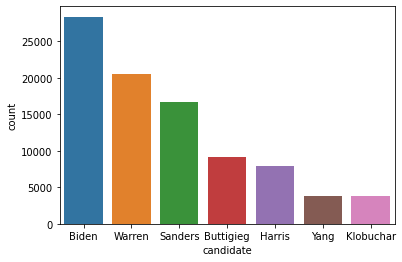

In [0]:
countplot(concat, x_col="candidate",  y_col=None, order=candidate_order)

# doesn't bias because its a large enough sample size

### Compare Verbs & Adjectives

#### Sentiment: `perspective(ws)`; `valence`

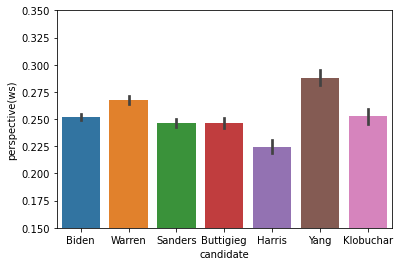

In [0]:
barplot(concat, x_col="candidate", y_col="perspective(ws)", ylim_low=.15, ylim_high=.35, pos="v", order=candidate_order)

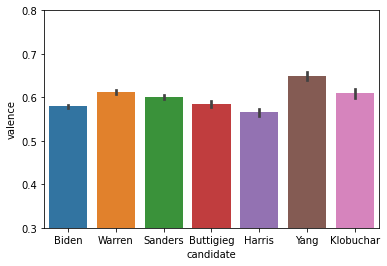

In [0]:
barplot(concat, x_col="candidate", y_col="valence", ylim_low=.3, ylim_high=.8, order=candidate_order)

#### Power / agency: `effect(o)`, `dominance`, `power`, `agency`

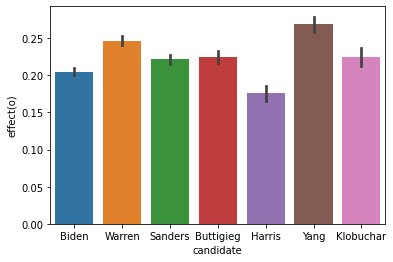

In [0]:
barplot(concat, x_col="candidate", y_col="effect(o)", ylim_low=0, ylim_high=0.3, order=candidate_order)

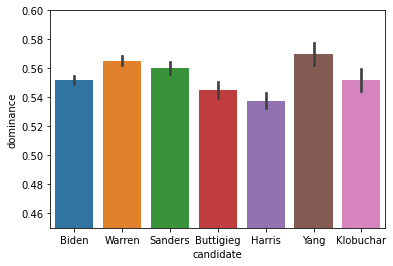

In [0]:
barplot(concat, x_col="candidate", y_col="dominance", ylim_low=0.45, ylim_high=0.6, order=candidate_order)

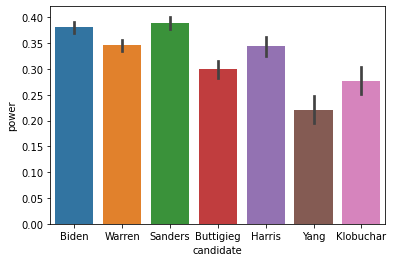

In [0]:
barplot(concat, x_col="candidate", y_col="power", ylim_low=0, ylim_high=0.42, order=candidate_order)

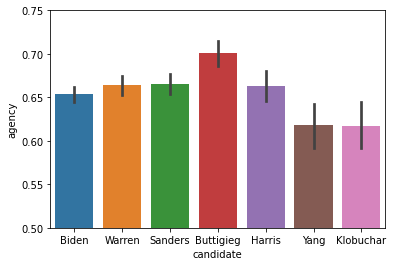

In [0]:
barplot(concat, x_col="candidate", y_col="agency", ylim_low=0.5, ylim_high=0.75, order=candidate_order)

#### Intensity: `arousal`

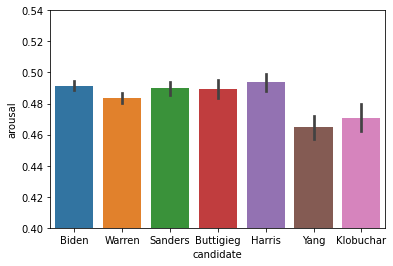

In [0]:
barplot(concat, x_col="candidate", y_col="arousal", ylim_low=0.4, ylim_high=0.54, order=candidate_order)

In [0]:
for k, v in concat[(concat["power"] ==-1)]["lemma"].value_counts().to_dict().items():
  print(k, v)

call 1512
ask 858
want 748
respond 575
become 506
join 374
need 370
believe 365
announce 327
receive 266
seek 237
lose 220
follow 217
mention 188
struggle 185
note 171
vote 165
serve 158
like 142
answer 126
explain 116
attend 113
thank 111
admit 108
hear 106
suffer 99
cite 96
miss 84
benefit 78
enjoy 74
visit 71
apologize 67
wish 65
represent 64
repeat 58
reiterate 52
prefer 48
recall 47
lack 43
reach 42
concede 40
outline 40
portray 40
appeal 38
credit 36
experience 34
promote 32
trust 32
greet 32
regard 31
wait 31
owe 31
require 28
learn 28
quote 28
predict 27
listen 27
collect 26
pursue 24
admire 23
respect 20
fill 17
accompany 17
regret 17
reflect 16
applaud 16
recognize 16
celebrate 16
wonder 15
donate 12
fear 12
underestimate 11
touch 11
achieve 11
elaborate 11
chase 11
hat 10
imitate 10
brush 10
consult 9
honor 9
implore 9
contribute 9
unload 7
enforce 7
congratulate 7
weather 7
duck 7
obey 6
relish 5
evade 5
beg 5
cheer 5
fan 5
brief 5
value 5
tip 5
endure 5
await 5
ascend 4
pl

In [0]:
print("Yang")
print("------")
for k, v in concat[(concat["valence"] > 0.8) & (concat["candidate"] == "Yang")]["lemma"].value_counts().to_dict().items():
  print(k,v)

Yang
------
praise 120
support 18
thank 18
hopeful 15
release 8
guarantee 8
agree 7
take 7
win 6
hope 5
promise 5
friend 5
love 4
find 3
celebrate 3
feel 2
proposal 2
advance 2
entrepreneur 2
encourage 2
earn 2
enjoy 2
hop 2
ride 2
bear 2
democratic 2
accomplish 2
engage 2
plan 2
maximize 1
accept 1
benefit 1
connect 1
exist 1
live 1
wonder 1
devote 1
thrive 1
inspire 1
teach 1
talk 1
protect 1
trust 1
complete 1
provide 1
children 1
improve 1
gain 1
advise 1
recognize 1
admire 1
welcome 1
appreciate 1
grow 1


In [0]:
# high power

for k, v in concat[(concat["power"] ==1)]["lemma"].value_counts().to_dict().items():
  print(k, v)

have 3040
do 1108
make 932
hold 925
lead 880
get 724
raise 666
show 639
accuse 626
include 617
investigate 600
give 535
criticize 520
add 497
write 497
use 476
win 464
attack 461
release 447
know 435
put 426
propose 417
rip 415
gain 411
defend 398
spend 347
bring 336
beat 324
claim 295
hit 290
plan 271
offer 266
push 266
leave 224
suggest 218
keep 193
draw 187
pay 179
challenge 178
drop 163
slam 155
acknowledge 154
introduce 150
saw 148
start 144
target 142
pledge 141
maintain 139
turn 137
refuse 135
pitch 134
pick 133
return 128
press 128
deliver 126
overtake 121
set 118
expect 118
force 118
launch 116
elect 114
play 114
insist 112
warn 112
build 111
fire 111
move 109
choose 108
shoot 107
name 105
pull 104
understand 104
hurt 103
open 102
share 101
enter 100
stop 95
end 95
send 95
question 94
deny 92
extend 91
dismiss 90
shut 89
close 87
decline 86
cast 85
cut 84
top 84
remind 82
blast 79
fail 75
allow 75
emphasize 72
mock 72
commit 71
walk 69
express 69
rattle 68
change 67
avoid 66
k

In [0]:
# low power
for k, v in concat[(concat["power"] ==-1)]["lemma"].value_counts().to_dict().items():
  print(k, v)

call 767
want 326
join 306
receive 242
lose 201
believe 201
need 169
note 160
admit 100
become 100
like 80
thank 80
ask 72
vote 62
wish 58
respond 58
mention 54
repeat 50
answer 47
seek 42
hear 38
represent 38
attend 34
explain 33
credit 33
experience 33
benefit 32
greet 31
prefer 30
miss 29
learn 27
require 26
collect 23
trust 23
visit 21
wait 21
respect 20
serve 20
apologize 20
pursue 19
follow 19
appeal 18
celebrate 15
portray 14
enjoy 14
struggle 14
fear 12
admire 11
regret 11
touch 11
achieve 11
recognize 10
imitate 9
honor 9
reach 8
owe 8
wonder 8
announce 7
quote 7
weather 7
accompany 7
reflect 6
outline 6
lack 6
unload 6
enforce 6
obey 6
cheer 5
chase 5
listen 5
recall 4
disappoint 4
offend 4
beg 3
mingle 3
applaud 3
mind 3
regard 3
suffer 3
tip 3
satisfy 3
uphold 3
oblige 3
promote 3
pray 3
fill 3
cite 3
interest 2
plead 2
elaborate 2
consult 2
endure 2
depart 2
donate 2
underestimate 2
concede 2
fulfil 2
value 2
contribute 2
mimic 1
desire 1
tail 1
chant 1
predict 1
delight 1

In [0]:
# high sentiment
for k, v in concat[(concat["valence"] > .8)]["lemma"].value_counts().to_dict().items():
  print(k, v)

praise 673
support 480
release 378
gain 330
lead 237
take 226
find 222
win 189
hopeful 138
raise 102
thank 80
love 58
engage 53
feel 51
provide 46
talk 40
agree 39
view 38
advise 37
hop 35
protect 34
hope 33
benefit 32
comply 29
trust 23
favor 22
accept 22
encourage 22
boost 21
increase 21
rise 21
improve 20
respect 20
reassure 20
promise 19
welcome 18
guarantee 17
bear 16
approve 16
plan 16
teach 15
celebrate 15
democratic 14
enjoy 14
smile 14
leading 13
share 13
embrace 12
appreciate 12
earn 12
play 12
new 12
admire 11
achieve 11
clear 11
distinguish 10
grow 10
young 10
impress 10
assure 10
inspire 10
advance 10
connect 10
honor 9
complete 9
choose 9
travel 9
proposal 9
friend 8
accomplish 8
learn 8
rely 8
wonder 8
recognize 7
excite 6
independent 6
remember 6
charm 5
accompany 5
strengthen 5
cheer 5
deserve 5
begin 5
greet 5
highlight 5
preserve 5
organize 4
arrive 4
devote 4
energetic 4
worth 4
elevate 4
responsible 4
succeed 4
secure 4
live 4
smiling 4
promote 3
dine 3
satisfy 3
a

In [0]:
# low sentiment
for k, v in concat[(concat["valence"] < 0.2)]["lemma"].value_counts().to_dict().items():
  print(k, v)

accuse 602
lose 201
refuse 113
shoot 103
hurt 103
force 96
oppose 91
deny 81
beat 52
stress 43
reject 41
criticize 40
defeat 39
leave 37
threaten 36
end 30
stick 26
argue 25
ridicule 20
die 20
blame 18
worry 16
fail 14
shake 14
ban 14
abandon 14
destroy 13
disagree 11
damage 10
lag 9
fear 9
discredit 8
dismiss 8
exclude 7
crush 7
punch 7
fall 6
infuriate 6
mock 6
dislike 6
stumble 6
steal 6
boycott 6
wind 5
abuse 5
hate 5
chase 5
fight 5
burn 5
violate 4
disappoint 4
trap 4
withdraw 4
ignore 4
fault 4
lie 4
prohibit 4
trash 4
complain 4
fire 4
offend 4
discourage 4
suspect 3
tear 3
bar 3
burst 3
weaken 3
restrict 3
irk 3
aggressive 3
suffer 3
scold 3
blast 3
sink 3
rid 3
derail 3
twist 3
frustrate 3
constrain 2
pretend 2
corrupt 2
shrink 2
clash 2
taint 2
dead 2
breach 2
plead 2
desperate 2
poor 2
halt 2
scorn 2
mislead 2
evasive 2
hack 2
kill 2
batter 2
weak 2
misrepresent 2
scar 2
scrap 2
upset 2
frustrated 2
intimidate 2
rip 2
swamp 2
strain 2
topple 2
junk 2
doom 2
slap 2
stricken 

In [0]:
# high dominance
for k, v in concat[(concat["dominance"] > .8)]["lemma"].value_counts().to_dict().items():
  print(k, v)

gain 330
lead 237
win 189
qualify 76
engage 53
defend 50
fight 36
campaign 33
benefit 32
experience 29
represent 22
progressive 22
increase 21
promise 20
guarantee 17
propel 17
build 16
leading 13
earn 12
dominate 12
force 11
demonstrate 11
finance 10
overcome 10
choose 9
respect 8
fund 7
legalize 7
learn 7
advocate 7
independent 6
advance 6
enforce 6
admire 6
strengthen 5
govern 5
protect 5
combat 5
highlight 5
improve 5
achieve 5
presidential 5
responsible 4
honor 4
teach 4
demand 4
succeed 4
fire 4
combative 4
energetic 4
secure 4
worth 4
resuscitate 4
elevate 4
project 3
regard 3
order 3
commitment 3
provide 3
found 3
develop 3
accomplish 3
able 3
burst 3
institute 3
command 3
promote 3
healthy 3
amplify 2
federal 2
ascendant 2
compromise 2
convince 2
assert 2
empower 2
famous 2
authorize 2
impassioned 2
powerful 2
deft 2
entrepreneur 2
value 2
capitalize 2
control 2
energize 2
instruct 2
trump 2
confirm 2
judge 1
consolidate 1
armed 1
certify 1
salvage 1
triumph 1
exert 1
protecti

In [0]:
# low dominance
for k, v in concat[(concat["dominance"] < .2)]["lemma"].value_counts().to_dict().items():
  print(k, v)

lose 172
refuse 96
go 35
slow 21
defeat 18
fade 18
confuse 7
abandon 7
exclude 7
forget 6
weaken 5
fault 4
neglect 4
fail 4
trash 4
damage 3
diminish 3
discourage 3
roll 3
less 3
plead 2
scrap 2
lack 2
sink 2
low 2
shy 2
poor 2
dead 2
weak 2
junk 2
unwillingness 2
underestimate 2
handicap 1
discredit 1
mourn 1
damaged 1
unpopular 1
fragile 1
mute 1
confused 1
blunder 1
puny 1
unconvincing 1
retire 1
subordinate 1
waste 1
doubting 1
absent 1
surrender 1


In [0]:
# high arousal
for k, v in concat[(concat["arousal"] == 1)]["lemma"].value_counts().to_dict().items():
  print(k, v)

In [0]:
# low arousal
for k, v in concat[(concat["arousal"] == -1)]["lemma"].value_counts().to_dict().items():
  print(k, v)

In [0]:
from collections import defaultdict
import math
import operator

In [0]:
def log_odds(counts1, counts2, prior, zscore = True):
  """Calculates and prints out the most distintive words between two groups.
  
  Arguments:
    counts1: dictionary of word counts for group 1
    counts2: dictionary of word counts for group 2
    prior: dictionary of word counts for all the data
    zscore: whether to normalize the final score (good to keep it as "True")
  """

  sigmasquared = defaultdict(float)
  sigma = defaultdict(float)
  delta = defaultdict(float)

  n1 = sum(counts1.values())
  n2 = sum(counts2.values())

  # since we use the sum of counts from the two groups as a prior, this is equivalent to a simple log odds ratio
  nprior = sum(prior.values())
  for word in prior.keys():
    if prior[word] == 0:
      delta[word] = 0
      continue
    l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
    l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
    sigmasquared[word] = 1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
    sigma[word] = math.sqrt(sigmasquared[word])
    delta[word] = (math.log(l1) - math.log(l2))
    if zscore:
      delta[word] /= sigma[word]
  
  sorted_scores = sorted(delta.items(), key=operator.itemgetter(1))
  
    
  most_associated = []
  for k, v in reversed(sorted_scores[-20:]):
    if v >= 2:
      most_associated.append((k,v))
  
  least_associated = []
  for k, v in sorted_scores[:10]:
    if v <= -2:
      least_associated.append((k,v))
  
  return most_associated, least_associated

In [0]:
def most_least(candidate):
  candidate_df = concat[concat['candidate'] == candidate]
  not_df = concat[concat['candidate'] != candidate]

  counts = Counter(candidate_df["lemma"])
  not_counts = Counter(not_df["lemma"])
  prior_counts = Counter(concat["lemma"])

  most, least = log_odds(counts, not_counts, prior_counts)
  
  print(candidate)
  print("Most associated")
  for word, value in most:
    print(word)
    print(value)
    if word in valence:
      print("valence", valence[word])
    if word in dominance:
      print("dominance", dominance[word])
    if word in arousal:
      print("arousal", arousal[word])
    if word in power:
      print("power", power[word])
    if word in agency:
      print("agency", agency[word])
    print("----")
  
  print("Least associated")
  for word, value in least:
    print(word)
    print(value)
    if word in valence:
      print("valence", valence[word])
    if word in dominance:
      print("dominance", dominance[word])
    if word in arousal:
      print("arousal", arousal[word])
    if word in power:
      print("power", power[word])
    if word in agency:
      print("agency", agency[word])
    print("----")
  

In [0]:
for candidate in names:
  most_least(candidate)

Warren
Most associated
praise
14.717322846023125
valence 0.7759999999999999
dominance 0.6579999999999999
arousal 0.387
power 0.0
agency 1.0
----
be
6.518875261978999
valence 0.67
dominance 0.5539999999999999
arousal 0.24
----
pay
4.996198416989889
valence 0.514
dominance 0.5920000000000001
arousal 0.588
power 1.0
agency 0.0
----
sign
4.343284701996976
valence 0.62
dominance 0.397
arousal 0.48100000000000004
power 0.0
agency 1.0
----
release
3.9808507798567283
valence 0.74
dominance 0.741
arousal 0.606
power 1.0
agency 1.0
----
sell
3.552879137050143
valence 0.618
dominance 0.605
arousal 0.608
power 1.0
agency 1.0
----
refuse
3.454226166060432
valence 0.18
dominance 0.331
arousal 0.52
power 1.0
agency 1.0
----
transfer
3.2620853327095563
valence 0.7020000000000001
dominance 0.519
arousal 0.49
power 1.0
agency 1.0
----
impose
3.126436229102033
valence 0.503
dominance 0.745
arousal 0.721
power 1.0
agency 1.0
----
rise
3.0735675149493615
valence 0.667
dominance 0.745
arousal 0.593
power na

# Compare Sources

Compare sources across all dimensions.

### Compare Counts

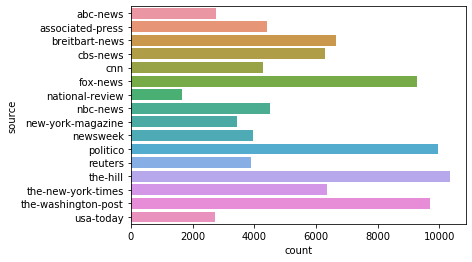

In [0]:
# In order to make it horizontal, set the "y_col" instead of the "x_col"
countplot(concat, x_col=None,  y_col="source")

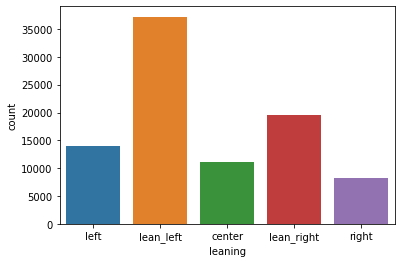

In [0]:
countplot(concat, x_col="leaning",  y_col=None, order=leaning_order)

### Compare Verbs & Adjectives

#### Sentiment: `perspective(ws)`; `valence`

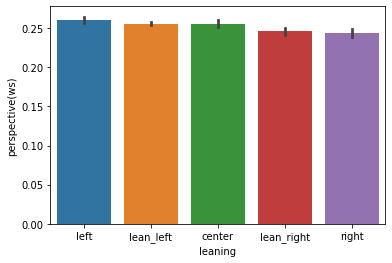

In [0]:
barplot(concat, x_col="leaning", y_col="perspective(ws)", order=leaning_order)

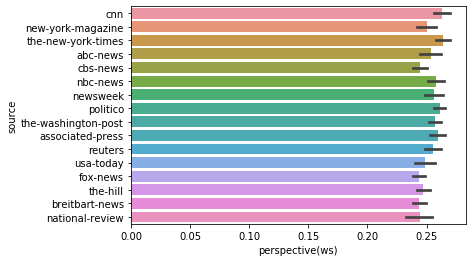

In [0]:
barplot(concat, y_col="source", x_col="perspective(ws)", pos="v", order=source_order)

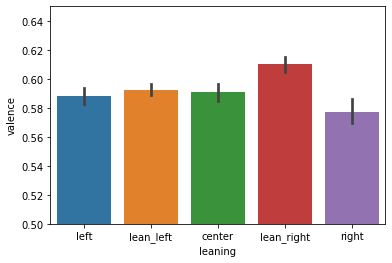

In [0]:
barplot(concat, x_col="leaning", y_col="valence", ylim_low=.5, ylim_high=.65, order=leaning_order)

#### Power / agency: `effect(o)`, `dominance`, `power`, `agency`

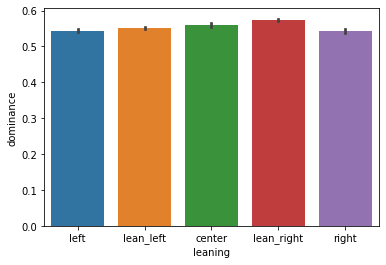

In [0]:
barplot(concat, x_col="leaning", y_col="dominance", ylim_low=0, ylim_high=0.6, order=leaning_order)

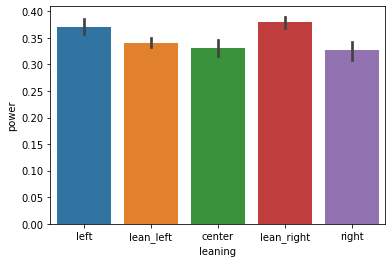

In [0]:
barplot(concat, x_col="leaning", y_col="power", ylim_low=0, ylim_high=0.42, order=leaning_order)

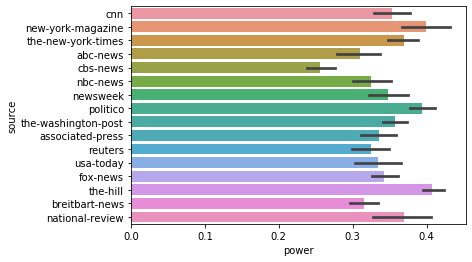

In [0]:
barplot(concat, y_col="source", x_col="power", pos="v", order=source_order)

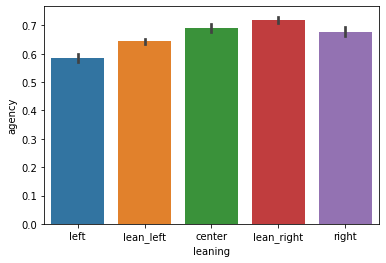

In [0]:
barplot(concat, x_col="leaning", y_col="agency", ylim_low=0, ylim_high=0.8, order=leaning_order)

#### Intensity: `arousal`

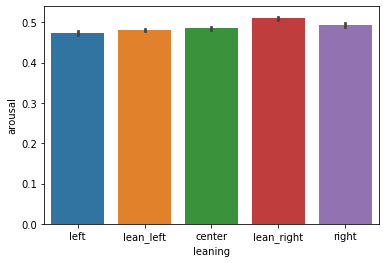

In [0]:
barplot(concat, x_col="leaning", y_col="arousal", ylim_low=0, ylim_high=0.58, order=leaning_order)

# Compare Time

Compare time across all dimensions.

### Compare Counts

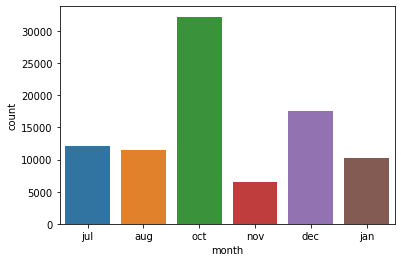

In [0]:
countplot(concat, x_col="month",  y_col=None, order=month_order)

### Compare Verbs & Adjectives

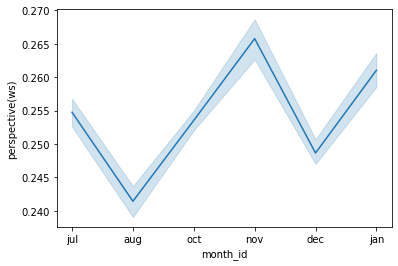

In [0]:
lineplot(concat, x_col="month_id", y_col="perspective(ws)", pos="v", xticks=month_order)

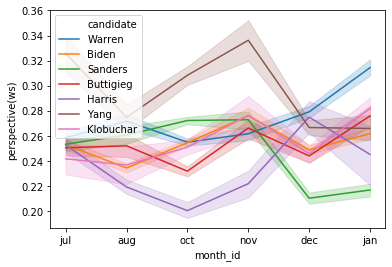

In [0]:
lineplot(concat, x_col="month_id", y_col="perspective(ws)", hue="candidate", pos="v", xticks=month_order)

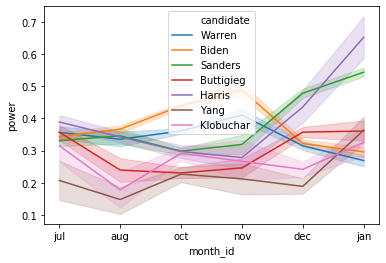

In [0]:
lineplot(concat, x_col="month_id", y_col="power", pos="v", xticks=month_order, hue="candidate")

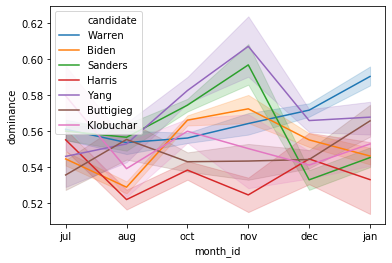

In [0]:
lineplot(concat, x_col="month_id", y_col="dominance", pos="v", xticks=month_order, hue="candidate")

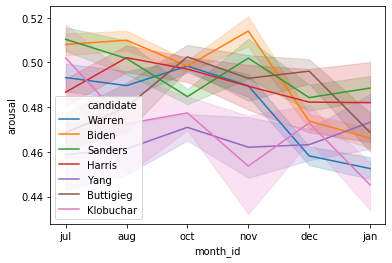

In [0]:
lineplot(concat, x_col="month_id", y_col="arousal", pos="v", xticks=month_order, hue="candidate")

In [0]:
month_order = ["jul","aug", "oct", "nov", "dec", "jan"]

In [0]:
polls['month'] = pd.Categorical(polls['month'],categories=["jul","aug", "oct", "nov", "dec", "jan"],ordered=True)


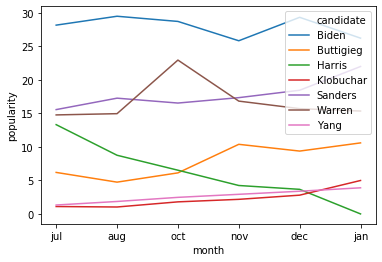

In [0]:
sns.lineplot(data=polls, x="month", y="popularity", hue="candidate", sort=False)

In [0]:
def z_rescale(values):
  return (values - min(values))/(max(values)-min(values))

In [0]:
polls["rescaled_popularity"]=polls.groupby("candidate")["popularity"].apply(z_rescale)

In [0]:
concat = concat[~concat["valence"].isnull()]

In [0]:
pearsonr(concat["popularity"], concat["valence"])

(-0.05979844272720429, 5.769215637938678e-27)

In [0]:
valence_dict = concat.groupby(["month", "candidate"])["valence"].mean().to_dict()
arousal_dict = concat.groupby(["month", "candidate"])["arousal"].mean().to_dict()
dominance_dict = concat.groupby(["month", "candidate"])["dominance"].mean().to_dict()


In [0]:
def map_valence(row):
  return valence_dict[(row["month"], row["candidate"])]

def map_arousal(row):
  return arousal_dict[(row["month"], row["candidate"])]

def map_dominance(row):
  return dominance_dict[(row["month"], row["candidate"])]

In [0]:
polls["valence"] = polls.apply(map_valence, axis=1)
polls["arousal"] = polls.apply(map_arousal, axis=1)
polls["dominance"] = polls.apply(map_dominance, axis=1)

In [0]:
polls["valence_rescaled"]=polls.groupby("candidate")["valence"].apply(z_rescale)
polls["arousal_rescaled"]=polls.groupby("candidate")["arousal"].apply(z_rescale)
polls["dominance_rescaled"]=polls.groupby("candidate")["dominance"].apply(z_rescale)

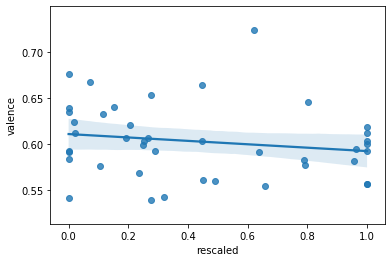

In [0]:
sns.regplot(data=polls, x="rescaled", y="valence")

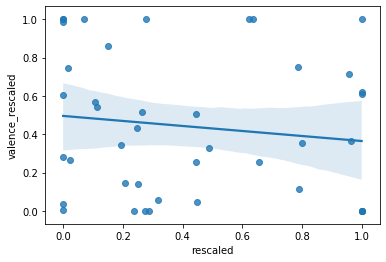

In [0]:
sns.regplot(data=polls, x="rescaled", y="valence_rescaled")

In [0]:
pearsonr(polls["rescaled"], polls["valence"])

(-0.1748030204625285, 0.26820028888439057)

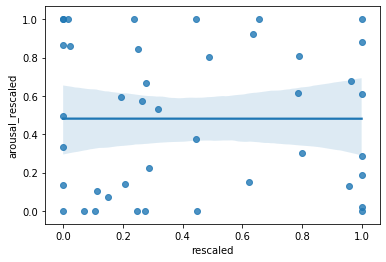

In [0]:
sns.regplot(data=polls, x="rescaled", y="arousal_rescaled")

In [0]:
pearsonr(polls["rescaled"], polls["arousal_rescaled"])

(-0.00045188563317107196, 0.9977338744284734)

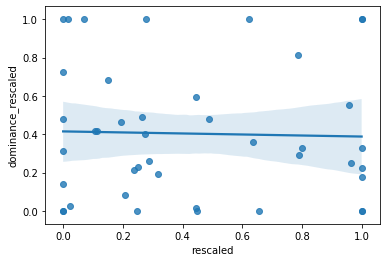

In [0]:
sns.regplot(data=polls, x="rescaled", y="dominance_rescaled")

In [0]:
pearsonr(polls["rescaled"], polls["dominance_rescaled"])

(-0.02926659298940846, 0.8540255829766169)

# Word Embeddings

In [0]:
from gensim.models import phrases, word2vec
import nltk
import numpy as np
import codecs
from collections import Counter
from nltk.corpus import stopwords
import argparse
import os
import string
import re
import pandas as pd
from gensim.models import KeyedVectors

In [0]:
def get_models(filelist):
    model_files = [f for f in filelist if f.endswith('.wv')]
    models = [KeyedVectors.load(fname, mmap='r') for fname in model_files]
    return models

In [0]:
filelist = []
for subdir, dirs, files in os.walk(root_dir + "models/word2vec_bootstrap"):
  for file in files:
    filelist.append(os.path.join(subdir, file))
models = get_models(filelist)
len(models)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


12

In [0]:
# Get vocab (intersection of all vocab)
vocab = set(models[0].vocab)
for m in models:
    vocab &= set(m.vocab)
len(vocab)

39653

In [0]:
idx2word = {i: w for i, w in enumerate(list(vocab))}

In [0]:
def get_closest(queries, models, vocab, idx2word):
    cosines = []
    for m in models:
        cosines.append([np.mean([m.similarity(q, word) for q in queries]) for word in vocab])
    cosines = np.mean(np.array(cosines), axis=0)
    return [(idx2word[idx], cosines[idx]) for idx in cosines.argsort()[-20:][::-1]]

In [0]:
def filter_words(words, vocab):
    words = set(words)
    not_in_vocab = words - vocab
    if not_in_vocab:
        print("Not in vocab:")
        print(not_in_vocab)
    return list(words - not_in_vocab)

In [0]:
queries = ["power"] # this should be a list of queries (it can also be just one query)

 # Remove queries not in vocab
queries = filter_words(queries, vocab)

print("Getting most similar words...")
closest = get_closest(queries, models, vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))

Getting most similar words...


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


power 1.00
personal gain 0.50
powers 0.49
abusing 0.48
authority 0.48
office to solicit 0.48
corrupting 0.47
trump abused 0.46
wield 0.45
levers 0.45
public trust 0.45
leverage 0.45
pressuring a foreign 0.45
exert 0.45
accused of abusing 0.45
personal interests 0.44
wields 0.44
speak truth 0.44
subvert 0.44
powers of the presidency 0.43


In [0]:
from scipy.stats import ttest_ind

In [0]:
def get_cosines(name1, name2, words1, words2, queries, models):
    df_w1 = []
    df_w2 = []
    df_q = []
    df_type = []
    df_pvals = []
    for key, values in queries.items():
        for q in values:
            vals1 = [m.similarity(word1, q) for m in models for word1 in words1]
            vals2 = [m.similarity(word2, q) for m in models for word2 in words2]
            df_w1.append(np.mean(vals1))
            df_w2.append(np.mean(vals2))
            df_q.append(q)
            df_type.append(key)
            df_pvals.append(ttest_ind(vals1, vals2)[1])
    df = pd.DataFrame({name1: df_w1, name2: df_w2, 'query': df_q, 'word category': df_type, "p value": df_pvals})
    return df

In [0]:
queries = {"power": ["powerful", "power", "authority", "powers", "influence"], 
           "achievement": ["achieved", "success", "successful"],
           "high power" : ["make", "lead", "show", "accuse", "include", "investigate", "criticize", "win", "attack", "release"],
           "high valence": ["gain", "win", "hopeful", "praise", "thank", "love", "hope", "agree", "respect", "encourage", "improve", "welcome", "smile", "inspire", "friend", "laugh"],
           "high dominance": ["lead", "experience", "win", "dominate", "force", "govern", "succeed", "command"],
           "high arousal": ["hit", "attack", "threaten", "challenge", "clash", "destroy", "infuriate", "excite", "fight", "violate", "aggressive"],
           }
words1 = ["biden", "joe", "joe biden"]
words2 =  ["harris", "kamala", "kamala harris"]
# Remove queries not in vocab
words1 = filter_words(words1, vocab)
words2 = filter_words(words2, vocab)
for k, v in queries.items():
    queries[k] = filter_words(v, vocab)

In [0]:
get_cosines("biden", "harris", words1, words2, queries, models)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,biden,harris,query,word category,p value
0,0.114221,0.058599,powers,power,4.337402e-07
1,0.134362,0.130164,powerful,power,6.834748e-01
2,0.142737,0.132648,power,power,4.968025e-01
3,0.103325,0.104095,authority,power,9.324482e-01
4,0.189965,0.122018,influence,power,4.248156e-06
5,0.220130,0.218858,achieved,achievement,9.316430e-01
6,0.168594,0.170308,success,achievement,8.819398e-01
7,0.178649,0.182172,successful,achievement,7.252677e-01
8,0.102458,0.114208,include,high power,1.591448e-01
9,0.215711,0.116729,win,high power,1.112161e-18


In [0]:
cosines_df = get_cosines("warren", "harris", words1, words2, queries, models)
grouped_df = cosines_df.groupby("word category")
print(grouped_df.mean())

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


                  warren    harris   p value
word category                               
achievement     0.181335  0.190446  0.031143
high arousal    0.172435  0.201816  0.191876
high dominance  0.163007  0.172447  0.276668
high power      0.144053  0.162870  0.212853
high valence    0.186249  0.215174  0.159513
power           0.110380  0.109505  0.186551


# Word Embeddings Sources

In [0]:
filelist_sources = []
for subdir, dirs, files in os.walk(root_dir + "models/word2vec_sources"):
  for file in files:
    filelist_sources.append(os.path.join(subdir, file))
models_sources = get_models(filelist_sources)
len(models_sources)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


16

In [0]:
vocab_sources = set(models_sources[0].vocab)
for m in models_sources:
    vocab_sources &= set(m.vocab)
len(vocab_sources)

2430